In [1]:
%%time
import fastai
from fastai.vision.all import *
import tensorflow as tf
from pathlib import Path
from tfrecord.tfrecord import *
torch.cuda.empty_cache()

Instructions for updating:
non-resource variables are not supported in the long term
CPU times: user 2.73 s, sys: 1.17 s, total: 3.9 s
Wall time: 3.15 s


In [2]:
%%time
def unpack_sample(feats):
    return {
        'class' : unpack_int64_list(feats['class']),
        'image' : unpack_bytes_list(feats['image'])
    }

CPU times: user 9 µs, sys: 3 µs, total: 12 µs
Wall time: 18.4 µs


In [3]:
path = Path.cwd()/"flowers/tfrecords-jpeg-224x224"

In [4]:
%%time
train_fnames = get_files(path/'train', extensions = '.tfrec')
test_fnames = get_files(path/'val', extensions = '.tfrec')

CPU times: user 4.94 ms, sys: 381 µs, total: 5.32 ms
Wall time: 3.43 ms


In [5]:
%%time
data = []
for name in train_fnames + test_fnames :
    r = Reader(str(name), unpack_sample)
    for sample in r :
        data.append([sample['image'][0], sample['class'][0]])
    #break

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
CPU times: user 669 ms, sys: 364 ms, total: 1.03 s
Wall time: 1.03 s


In [6]:
%%time

get_y = lambda x: x[1]

get_x = lambda x: PILImage.create(io.BytesIO(x[0]))

def get_items(noop):
    return data

def get_dls(size , bs):
    flowers = DataBlock(blocks = (ImageBlock, CategoryBlock),
                        get_items = get_items,
                        get_x = get_x, get_y = get_y,
                        item_tfms = Resize(440),
                        batch_tfms = [*aug_transforms(size = size, min_scale = 0.75), Normalize.from_stats(*imagenet_stats)])
    
    return flowers.dataloaders("", bs = bs, device = "cuda")

CPU times: user 12 µs, sys: 5 µs, total: 17 µs
Wall time: 24.1 µs


In [8]:
%%time
dls = get_dls(128, 128)

CPU times: user 810 ms, sys: 3.28 ms, total: 813 ms
Wall time: 767 ms


CPU times: user 1.23 s, sys: 119 ms, total: 1.35 s
Wall time: 967 ms


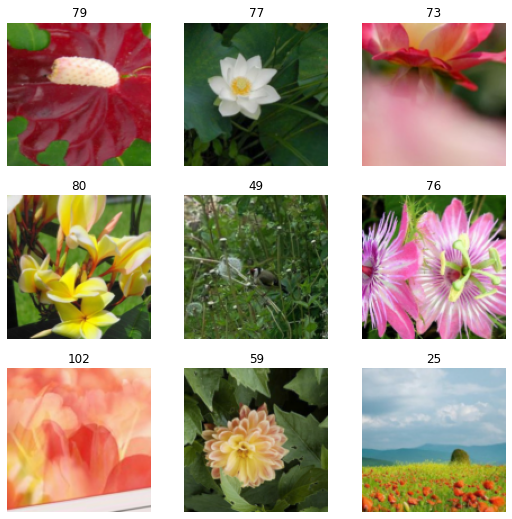

In [9]:
%%time
dls.show_batch()

CPU times: user 1.26 s, sys: 99.8 ms, total: 1.36 s
Wall time: 968 ms


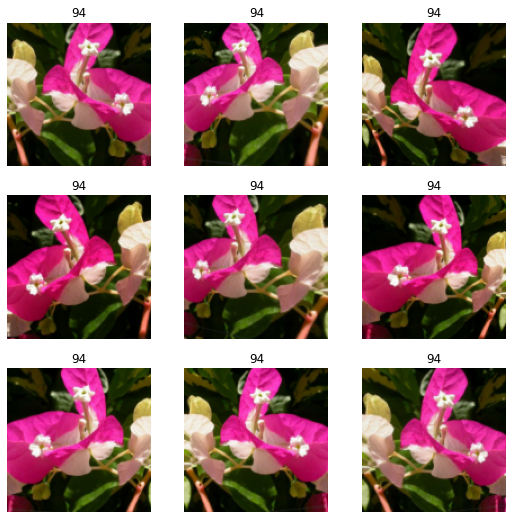

In [10]:
%%time
dls.show_batch(unique = True)

In [11]:
%%time
model = xresnet34()

learn = Learner(dls, model, loss_func = LabelSmoothingCrossEntropyFlat(), metrics = accuracy, cbs = MixUp())

CPU times: user 360 ms, sys: 18.3 ms, total: 378 ms
Wall time: 375 ms


In [12]:
%%time

learn.fit_one_cycle(13, slice(1e-5, 1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,4.312562,4.004644,0.204069,00:29
1,4.026235,3.888225,0.233526,00:29
2,3.790277,3.480257,0.293350,00:29
3,3.563696,3.382016,0.314303,00:29
4,3.339537,2.858750,0.461585,00:29
5,3.117919,2.723431,0.490738,00:29
6,2.955932,2.554212,0.555117,00:29
7,2.840219,2.274188,0.624658,00:29
8,2.687430,2.130636,0.673246,00:28
9,2.581640,2.037041,0.709384,00:28


/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


CPU times: user 3min 37s, sys: 1min 38s, total: 5min 16s
Wall time: 6min 20s


CPU times: user 52.2 ms, sys: 9.82 ms, total: 62 ms
Wall time: 58.2 ms


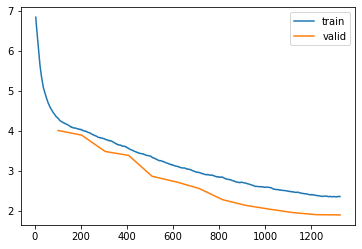

In [13]:
%%time

learn.recorder.plot_loss()

In [14]:
%%time

learn.dls = get_dls(224, 64)

CPU times: user 834 ms, sys: 8.82 ms, total: 843 ms
Wall time: 766 ms


In [15]:
%%time

learn.fine_tune(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.609014,1.729313,0.811418,00:56


epoch,train_loss,valid_loss,accuracy,time
0,2.504327,1.656729,0.835712,00:55
1,2.481848,1.637090,0.835408,00:55
2,2.439745,1.616656,0.847252,00:55
3,2.408720,1.615569,0.842393,00:55
4,2.386740,1.595963,0.846948,00:55
5,2.354977,1.576186,0.856666,00:55
6,2.331341,1.562871,0.858184,00:55
7,2.298722,1.556722,0.859702,00:55
8,2.282243,1.555895,0.858791,00:55
9,2.285243,1.551207,0.862132,00:55


CPU times: user 6min 23s, sys: 3min 19s, total: 9min 43s
Wall time: 10min 11s


CPU times: user 64.3 ms, sys: 14.2 ms, total: 78.5 ms
Wall time: 73.9 ms


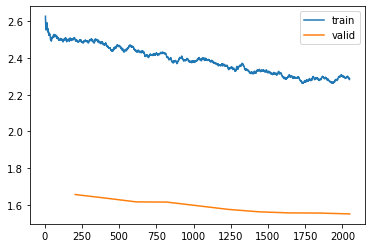

In [16]:
%%time
learn.recorder.plot_loss()

In [21]:
%%time

preds, targs = learn.tta(n = 6)

CPU times: user 31.9 s, sys: 8.5 s, total: 40.4 s
Wall time: 48.2 s


In [22]:
%%time

accuracy(preds, targs)

CPU times: user 34.9 ms, sys: 0 ns, total: 34.9 ms
Wall time: 6.4 ms


TensorBase(0.8652)

In [23]:
%%time

interp = ClassificationInterpretation.from_learner(learn)

CPU times: user 5.43 s, sys: 4.45 s, total: 9.88 s
Wall time: 8.4 s


CPU times: user 515 ms, sys: 50.8 ms, total: 565 ms
Wall time: 353 ms


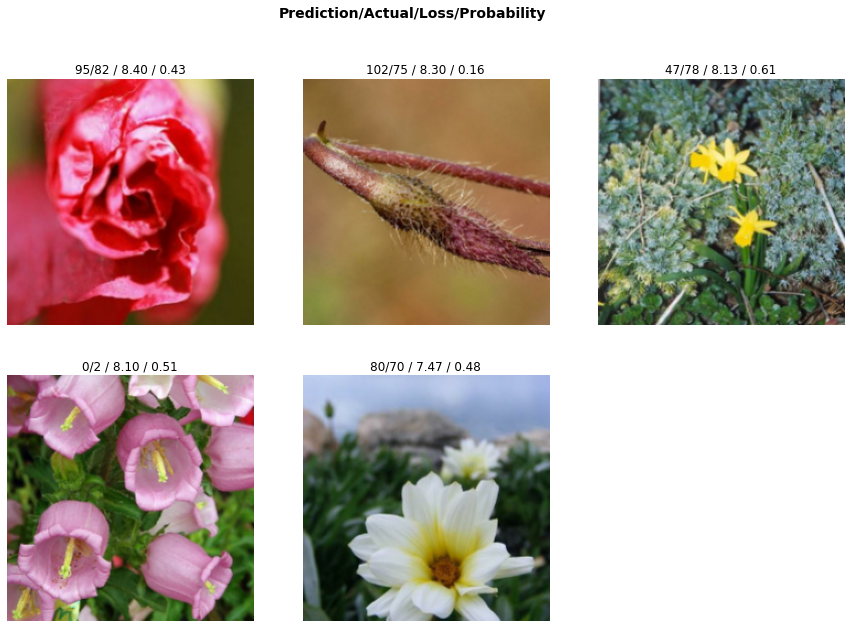

In [24]:
%%time

interp.plot_top_losses(5, nrows = 2, figsize = (15, 10))

In [29]:
%%time

path = Path.cwd()

CPU times: user 119 µs, sys: 56 µs, total: 175 µs
Wall time: 111 µs


In [34]:
%%time

learn.save('final_model1')

CPU times: user 108 ms, sys: 47.9 ms, total: 156 ms
Wall time: 153 ms


Path('models/final_model1.pth')